# Notebook 4: Modular Cardiac Synchrony Analysis Framework

## Overview

This notebook provides a **flexible, modular framework** for computing cardiac synchrony between two participants using multiple methods.

### Key Features:

- **Single analysis function** with method selection
- **Multiple synchrony metrics**:
  - Pearson correlation (instantaneous)
  - Cross-correlation with lag detection
  - Coherence (frequency-domain)
  - Phase Locking Index (PLI)
  - Envelope correlation
  - Cross-Recurrence Quantification Analysis (CRQA)
- **Works with**: Heart rate time series OR RR intervals
- **Windowed analysis** support
- **Easy to extend** with new methods

### When to Use Which Method:

| Method | Best For | Captures |
|--------|----------|----------|
| **Correlation** | Quick assessment | Linear relationship |
| **Cross-correlation** | Leader-follower | Temporal dynamics, lag |
| **Coherence** | Frequency analysis | Shared rhythms in specific bands |
| **PLI** | Phase coupling | Consistent phase relationship |
| **Envelope** | Amplitude coupling | Co-modulation of signal envelopes |
| **CRQA** | Nonlinear dynamics | Recurrent patterns, determinism |

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm

# Signal processing
from scipy import signal, stats
from scipy.signal import detrend, hilbert, coherence, correlate
import neurokit2 as nk

# Optional: CRQA
try:
    from pyrqa.time_series import TimeSeries
    from pyrqa.settings import Settings
    from pyrqa.analysis_type import Cross
    from pyrqa.neighbourhood import FixedRadius
    from pyrqa.metric import EuclideanMetric
    from pyrqa.computation import RQAComputation
    PYRQA_AVAILABLE = True
except ImportError:
    PYRQA_AVAILABLE = False
    print(" PyRQA not available. Install with: pip install PyRQA")

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Data from Previous Notebooks

In [2]:
# Load from previous notebooks
# Use relative paths for portability
data_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/processed_data")
results_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/analysis_results")

# Load metadata
with open(data_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

# Load heart rate data from Notebook 3 (R-peak based)
hr_p1 = pd.read_csv(results_dir / f"hr_rpeak_{metadata['participant_1']}.csv")
hr_p2 = pd.read_csv(results_dir / f"hr_rpeak_{metadata['participant_2']}.csv")

print(f"✓ Loaded data for {metadata['participant_1']} and {metadata['participant_2']}")
print(f"  P1: {len(hr_p1)} samples")
print(f"  P2: {len(hr_p2)} samples")

✓ Loaded data for Participant_A and Participant_B
  P1: 2152 samples
  P2: 2142 samples


## 3. Preprocessing Utilities

These functions prepare the data for synchrony analysis.

In [3]:
def prepare_signals(hr1, hr2, time1, time2, detrend_signal=True, standardize=True):
    """
    Prepare two heart rate signals for synchrony analysis.
    
    Parameters:
    -----------
    hr1, hr2 : array-like
        Heart rate time series for participants 1 and 2
    time1, time2 : array-like
        Time arrays for each participant
    detrend_signal : bool
        Whether to remove linear trend
    standardize : bool
        Whether to z-score normalize
        
    Returns:
    --------
    hr1_clean, hr2_clean : array
        Processed signals of equal length
    time_common : array
        Common time base
    """
    # Find common time range
    start_time = max(time1[0], time2[0])
    end_time = min(time1[-1], time2[-1])
    
    # Trim to common range
    mask1 = (time1 >= start_time) & (time1 <= end_time)
    mask2 = (time2 >= start_time) & (time2 <= end_time)
    
    hr1_trim = np.array(hr1[mask1])
    hr2_trim = np.array(hr2[mask2])
    time_common = np.array(time1[mask1])
    
    # Ensure same length
    min_len = min(len(hr1_trim), len(hr2_trim))
    hr1_trim = hr1_trim[:min_len]
    hr2_trim = hr2_trim[:min_len]
    time_common = time_common[:min_len]
    
    # Detrend
    if detrend_signal:
        hr1_trim = detrend(hr1_trim, type='linear')
        hr2_trim = detrend(hr2_trim, type='linear')
    
    # Standardize
    if standardize:
        hr1_trim = stats.zscore(hr1_trim, nan_policy='omit')
        hr2_trim = stats.zscore(hr2_trim, nan_policy='omit')
    
    # Handle NaN values
    hr1_trim = np.nan_to_num(hr1_trim)
    hr2_trim = np.nan_to_num(hr2_trim)
    
    return hr1_trim, hr2_trim, time_common


def ensure_same_length(x, y):
    """Ensure two arrays have the same length."""
    if len(x) != len(y):
        min_len = min(len(x), len(y))
        return x[:min_len], y[:min_len]
    return x, y


print(" Preprocessing utilities loaded")

 Preprocessing utilities loaded


## 4. Core Synchrony Metrics

Each metric is implemented as a standalone function that can be called independently.

### 4.1 Pearson Correlation

In [4]:
def correlation_synchrony(x, y):
    """
    Compute Pearson correlation between two time series.
    
    Returns:
    --------
    dict with keys: 'r' (correlation), 'p' (p-value)
    """
    x, y = ensure_same_length(x, y)
    
    if len(x) < 3:
        return {'r': np.nan, 'p': np.nan}
    
    r, p = stats.pearsonr(x, y)
    
    return {
        'r': float(r),
        'p': float(p)
    }

print(" Correlation function loaded")

 Correlation function loaded


### 4.2 Cross-Correlation with Lag

In [5]:
def xcorr_synchrony(x, y, sampling_rate=4, max_lag_s=10):
    """
    Compute cross-correlation and detect lag.
    
    Parameters:
    -----------
    x, y : array
        Time series
    sampling_rate : float
        Sampling rate in Hz
    max_lag_s : float
        Maximum lag to search (seconds)
        
    Returns:
    --------
    dict with keys: 'max_corr' (correlation at peak), 'lag_s' (lag in seconds)
    """
    x, y = ensure_same_length(x, y)
    
    if len(x) < 10:
        return {'max_corr': np.nan, 'lag_s': np.nan}
    
    max_lag = int(max_lag_s * sampling_rate)
    
    # Center the signals
    x0 = x - np.nanmean(x)
    y0 = y - np.nanmean(y)
    x0 = np.nan_to_num(x0)
    y0 = np.nan_to_num(y0)
    
    # Compute cross-correlation
    corr = correlate(x0, y0, mode='full', method='fft')
    lags = np.arange(-len(x0) + 1, len(x0))
    
    # Limit to max_lag
    mask = (lags >= -max_lag) & (lags <= max_lag)
    corr = corr[mask]
    lags = lags[mask]
    
    # Normalize
    denom = np.sqrt(np.sum(x0**2) * np.sum(y0**2))
    if denom == 0:
        return {'max_corr': np.nan, 'lag_s': np.nan}
    
    corr_norm = corr / denom
    
    # Find peak
    peak_idx = int(np.nanargmax(np.abs(corr_norm)))
    max_corr = float(corr_norm[peak_idx])
    lag_samples = float(lags[peak_idx])
    lag_s = lag_samples / sampling_rate
    
    return {
        'max_corr': max_corr,
        'lag_s': float(lag_s)
    }

print(" Cross-correlation function loaded")

 Cross-correlation function loaded


### 4.3 Coherence (Frequency Domain)

In [6]:
def coherence_synchrony(x, y, sampling_rate=4, fmin=0.04, fmax=0.4):
    """
    Compute mean coherence in a frequency band.
    
    Parameters:
    -----------
    x, y : array
        Time series
    sampling_rate : float
        Sampling rate in Hz
    fmin, fmax : float
        Frequency band limits (Hz)
        
    Returns:
    --------
    dict with key: 'mean_coherence'
    """
    x, y = ensure_same_length(x, y)
    
    if len(x) < 256:  # Need enough samples for coherence
        return {'mean_coherence': np.nan}
    
    try:
        # Compute coherence
        nperseg = min(256, len(x) // 4)  # Adaptive segment length
        f, Cxy = coherence(x, y, fs=sampling_rate, nperseg=nperseg, noverlap=nperseg//2)
        
        # Extract band of interest
        band_mask = (f >= fmin) & (f <= fmax)
        
        if not np.any(band_mask):
            return {'mean_coherence': np.nan}
        
        mean_coh = float(np.nanmean(Cxy[band_mask]))
        
        return {'mean_coherence': mean_coh}
        
    except Exception as e:
        print(f"Coherence error: {e}")
        return {'mean_coherence': np.nan}

print(" Coherence function loaded")

 Coherence function loaded


### 4.4 Phase Locking Index (PLI)

In [7]:
def pli_synchrony(x, y):
    """
    Compute Phase Locking Index using Hilbert transform.
    
    Measures consistency of phase relationship between signals.
    Range: 0 (no locking) to 1 (perfect locking)
    
    Returns:
    --------
    dict with key: 'pli'
    """
    x, y = ensure_same_length(x, y)
    
    if len(x) < 10:
        return {'pli': np.nan}
    
    try:
        # Get instantaneous phase via Hilbert transform
        phase_x = np.angle(hilbert(x))
        phase_y = np.angle(hilbert(y))
        
        # Phase difference
        phase_diff = phase_x - phase_y
        
        # PLI = |<sign(sin(phase_diff))>|
        pli = float(np.abs(np.nanmean(np.sign(np.sin(phase_diff)))))
        
        return {'pli': pli}
        
    except Exception as e:
        print(f"PLI error: {e}")
        return {'pli': np.nan}

print(" PLI function loaded")

 PLI function loaded


### 4.5 Envelope Correlation

In [8]:
def envelope_synchrony(x, y):
    """
    Compute correlation of signal envelopes (amplitude coupling).
    
    Measures co-modulation of signal amplitudes over time.
    
    Returns:
    --------
    dict with key: 'envelope_corr'
    """
    x, y = ensure_same_length(x, y)
    
    if len(x) < 10:
        return {'envelope_corr': np.nan}
    
    try:
        # Get envelope (instantaneous amplitude)
        env_x = np.abs(hilbert(x))
        env_y = np.abs(hilbert(y))
        
        # Check for zero variance
        if np.std(env_x) == 0 or np.std(env_y) == 0:
            return {'envelope_corr': np.nan}
        
        # Correlate envelopes
        env_corr = float(np.corrcoef(env_x, env_y)[0, 1])
        
        return {'envelope_corr': env_corr}
        
    except Exception as e:
        print(f"Envelope correlation error: {e}")
        return {'envelope_corr': np.nan}

print(" Envelope correlation function loaded")

 Envelope correlation function loaded


### 4.6 Cross-Recurrence Quantification Analysis (CRQA)

In [9]:
def crqa_synchrony(x, y, dimension=3, time_delay=1, radius=0.1):
    """
    Perform Cross-Recurrence Quantification Analysis.
    
    Measures recurrent patterns between two time series.
    Requires PyRQA package.
    
    Parameters:
    -----------
    dimension : int
        Embedding dimension
    time_delay : int
        Time delay for embedding
    radius : float
        Radius for recurrence threshold
        
    Returns:
    --------
    dict with keys: 'RR', 'DET', 'L', 'LMAX', 'ENT', 'LAM', 'TT'
    """
    if not PYRQA_AVAILABLE:
        return {
            'RR': np.nan, 'DET': np.nan, 'L': np.nan, 
            'LMAX': np.nan, 'ENT': np.nan, 'LAM': np.nan, 'TT': np.nan
        }
    
    x, y = ensure_same_length(x, y)
    
    if len(x) < 50:
        return {
            'RR': np.nan, 'DET': np.nan, 'L': np.nan,
            'LMAX': np.nan, 'ENT': np.nan, 'LAM': np.nan, 'TT': np.nan
        }
    
    try:
        # Clean data
        x_clean = np.asarray(x, dtype=float)
        y_clean = np.asarray(y, dtype=float)
        
        # Remove NaN
        valid_idx = np.isfinite(x_clean) & np.isfinite(y_clean)
        if np.sum(valid_idx) < 50:
            return {
                'RR': np.nan, 'DET': np.nan, 'L': np.nan,
                'LMAX': np.nan, 'ENT': np.nan, 'LAM': np.nan, 'TT': np.nan
            }
        
        x_clean = x_clean[valid_idx]
        y_clean = y_clean[valid_idx]
        
        # Standardize
        x_clean = stats.zscore(x_clean, nan_policy='omit')
        y_clean = stats.zscore(y_clean, nan_policy='omit')
        
        # Create time series objects
        ts_x = TimeSeries(x_clean, embedding_dimension=dimension, time_delay=time_delay)
        ts_y = TimeSeries(y_clean, embedding_dimension=dimension, time_delay=time_delay)
        
        # Settings
        settings = Settings(
            ts_x, ts_y,
            neighbourhood=FixedRadius(radius),
            similarity_measure=EuclideanMetric(),
            theiler_corrector=1
        )
        settings.analysis_type = Cross()
        
        # Compute
        computation = RQAComputation.create(settings, verbose=False)
        result = computation.run()
        
        # Extract measures
        return {
            'RR': float(result.recurrence_rate),
            'DET': float(result.determinism),
            'L': float(result.average_diagonal_line),
            'LMAX': float(result.longest_diagonal_line),
            'ENT': float(result.entropy_diagonal_lines),
            'LAM': float(result.laminarity),
            'TT': float(result.average_white_vertical_line)
        }
        
    except Exception as e:
        print(f"CRQA error: {e}")
        return {
            'RR': np.nan, 'DET': np.nan, 'L': np.nan,
            'LMAX': np.nan, 'ENT': np.nan, 'LAM': np.nan, 'TT': np.nan
        }

print(" CRQA function loaded" if PYRQA_AVAILABLE else " CRQA function loaded but PyRQA not available")

 CRQA function loaded


## 5. Unified Synchrony Analysis Function

This is the **main function** that ties everything together. Call it with your data and specify which methods you want to use.

In [10]:
def compute_cardiac_synchrony(
    hr1, hr2, 
    time1=None, time2=None,
    sampling_rate=4,
    methods=['correlation', 'xcorr', 'coherence', 'pli', 'envelope', 'crqa'],
    detrend_signal=True,
    standardize=True,
    coherence_band=(0.04, 0.4),
    max_lag_s=10,
    crqa_params=None
):
    """
    Compute cardiac synchrony using multiple methods.
    
    Parameters:
    -----------
    hr1, hr2 : array-like
        Heart rate time series for participants 1 and 2
    time1, time2 : array-like, optional
        Time arrays (if None, assumes regularly sampled)
    sampling_rate : float
        Sampling rate in Hz
    methods : list of str
        Which methods to compute. Options:
        - 'correlation': Pearson correlation
        - 'xcorr': Cross-correlation with lag
        - 'coherence': Frequency-domain coherence
        - 'pli': Phase Locking Index
        - 'envelope': Envelope correlation
        - 'crqa': Cross-Recurrence Quantification Analysis
    detrend_signal : bool
        Remove linear trend
    standardize : bool
        Z-score normalize
    coherence_band : tuple
        (fmin, fmax) for coherence analysis
    max_lag_s : float
        Maximum lag for cross-correlation (seconds)
    crqa_params : dict, optional
        Parameters for CRQA (dimension, time_delay, radius)
        
    Returns:
    --------
    dict : Results from all requested methods
    """
    # Convert to numpy arrays
    hr1 = np.asarray(hr1)
    hr2 = np.asarray(hr2)
    
    # Create time arrays if not provided
    if time1 is None:
        time1 = np.arange(len(hr1)) / sampling_rate
    if time2 is None:
        time2 = np.arange(len(hr2)) / sampling_rate
    
    # Prepare signals
    hr1_clean, hr2_clean, time_common = prepare_signals(
        hr1, hr2, time1, time2, detrend_signal, standardize
    )
    
    # Initialize results
    results = {
        'n_samples': len(hr1_clean),
        'duration_s': float(time_common[-1] - time_common[0]) if len(time_common) > 0 else np.nan,
        'sampling_rate': sampling_rate
    }
    
    # Compute each requested method
    if 'correlation' in methods:
        results['correlation'] = correlation_synchrony(hr1_clean, hr2_clean)
    
    if 'xcorr' in methods:
        results['xcorr'] = xcorr_synchrony(
            hr1_clean, hr2_clean, sampling_rate, max_lag_s
        )
    
    if 'coherence' in methods:
        fmin, fmax = coherence_band
        results['coherence'] = coherence_synchrony(
            hr1_clean, hr2_clean, sampling_rate, fmin, fmax
        )
        results['coherence']['band'] = coherence_band
    
    if 'pli' in methods:
        results['pli'] = pli_synchrony(hr1_clean, hr2_clean)
    
    if 'envelope' in methods:
        results['envelope'] = envelope_synchrony(hr1_clean, hr2_clean)
    
    if 'crqa' in methods:
        if crqa_params is None:
            crqa_params = {'dimension': 3, 'time_delay': 1, 'radius': 0.1}
        results['crqa'] = crqa_synchrony(hr1_clean, hr2_clean, **crqa_params)
    
    return results

print(" Main synchrony analysis function loaded")

 Main synchrony analysis function loaded


## 6. Example Usage: All Methods

In [11]:
# Prepare the data
hr1_data = hr_p1['HeartRate'].values
hr2_data = hr_p2['HeartRate'].values
time1_data = hr_p1['Time'].values
time2_data = hr_p2['Time'].values

# Compute synchrony using ALL methods
print("Computing synchrony with all methods...\n")
results_all = compute_cardiac_synchrony(
    hr1_data, hr2_data,
    time1=time1_data, time2=time2_data,
    sampling_rate=4,  # 4 Hz from interpolation in Notebook 3
    methods=['correlation', 'xcorr', 'coherence', 'pli', 'envelope', 'crqa'],
    coherence_band=(0.04, 0.4),  # LF + HF bands
    max_lag_s=10
)

# Display results
print("=" * 70)
print("CARDIAC SYNCHRONY ANALYSIS - ALL METHODS")
print("=" * 70)
print(f"\nData: {results_all['n_samples']} samples, {results_all['duration_s']:.1f}s duration\n")

# Correlation
if 'correlation' in results_all:
    print("📊 CORRELATION:")
    print(f"   r = {results_all['correlation']['r']:.3f}")
    print(f"   p = {results_all['correlation']['p']:.4e}\n")

# Cross-correlation
if 'xcorr' in results_all:
    print("↔️  CROSS-CORRELATION:")
    print(f"   Max correlation = {results_all['xcorr']['max_corr']:.3f}")
    print(f"   Lag = {results_all['xcorr']['lag_s']:.2f}s")
    if abs(results_all['xcorr']['lag_s']) < 1:
        print(f"   Interpretation: Synchronous\n")
    elif results_all['xcorr']['lag_s'] > 0:
        print(f"   Interpretation: P1 leads P2\n")
    else:
        print(f"   Interpretation: P2 leads P1\n")

# Coherence
if 'coherence' in results_all:
    print("🌊 COHERENCE:")
    print(f"   Mean coherence = {results_all['coherence']['mean_coherence']:.3f}")
    print(f"   Band: {results_all['coherence']['band']} Hz\n")

# PLI
if 'pli' in results_all:
    print("🔄 PHASE LOCKING INDEX:")
    print(f"   PLI = {results_all['pli']['pli']:.3f}")
    print(f"   Range: 0 (no locking) to 1 (perfect locking)\n")

# Envelope
if 'envelope' in results_all:
    print("📈 ENVELOPE CORRELATION:")
    print(f"   r = {results_all['envelope']['envelope_corr']:.3f}\n")

# CRQA
if 'crqa' in results_all and PYRQA_AVAILABLE:
    print("🔁 CROSS-RECURRENCE QUANTIFICATION:")
    print(f"   Recurrence Rate (RR) = {results_all['crqa']['RR']:.3f}")
    print(f"   Determinism (DET) = {results_all['crqa']['DET']:.3f}")
    print(f"   Average Line Length (L) = {results_all['crqa']['L']:.2f}")
    print(f"   Entropy (ENT) = {results_all['crqa']['ENT']:.3f}\n")

Computing synchrony with all methods...

CARDIAC SYNCHRONY ANALYSIS - ALL METHODS

Data: 2141 samples, 535.0s duration

📊 CORRELATION:
   r = 0.531
   p = 3.3377e-156

↔️  CROSS-CORRELATION:
   Max correlation = 0.551
   Lag = -4.25s
   Interpretation: P2 leads P1

🌊 COHERENCE:
   Mean coherence = 0.033
   Band: (0.04, 0.4) Hz

🔄 PHASE LOCKING INDEX:
   PLI = 0.170
   Range: 0 (no locking) to 1 (perfect locking)

📈 ENVELOPE CORRELATION:
   r = 0.168

🔁 CROSS-RECURRENCE QUANTIFICATION:
   Recurrence Rate (RR) = 0.020
   Determinism (DET) = 0.871
   Average Line Length (L) = 3.71
   Entropy (ENT) = 1.772



## 7. Example Usage: Quick Analysis (Correlation + Cross-correlation)

In [12]:
# For quick analysis, just use correlation and xcorr
print("Computing quick synchrony analysis...\n")
results_quick = compute_cardiac_synchrony(
    hr1_data, hr2_data,
    time1=time1_data, time2=time2_data,
    methods=['correlation', 'xcorr'],  # Just these two
    sampling_rate=4
)

print("Quick Synchrony Results:")
print(f"  Correlation: {results_quick['correlation']['r']:.3f}")
print(f"  XCorr peak: {results_quick['xcorr']['max_corr']:.3f} at lag {results_quick['xcorr']['lag_s']:.2f}s")

Computing quick synchrony analysis...

Quick Synchrony Results:
  Correlation: 0.531
  XCorr peak: 0.551 at lag -4.25s


## 8. Windowed Synchrony Analysis

Compute synchrony in sliding windows to see temporal dynamics.

In [13]:
def windowed_synchrony_analysis(
    hr1, hr2, time1, time2,
    window_size_s=30,
    overlap=0.5,
    sampling_rate=4,
    methods=['correlation', 'xcorr'],
    **kwargs
):
    """
    Compute synchrony in sliding windows.
    
    Parameters:
    -----------
    window_size_s : float
        Window size in seconds
    overlap : float
        Fraction of overlap (0-1)
    methods : list
        Synchrony methods to compute
    **kwargs : dict
        Additional arguments for compute_cardiac_synchrony
        
    Returns:
    --------
    list of dict : Results for each window
    """
    # Prepare signals
    hr1_clean, hr2_clean, time_common = prepare_signals(
        hr1, hr2, time1, time2, detrend_signal=True, standardize=True
    )
    
    window_samples = int(window_size_s * sampling_rate)
    step_samples = int(window_samples * (1 - overlap))
    
    results_list = []
    
    for start in range(0, len(hr1_clean) - window_samples + 1, step_samples):
        end = start + window_samples
        
        # Extract window
        hr1_window = hr1_clean[start:end]
        hr2_window = hr2_clean[start:end]
        time_window = time_common[start:end]
        
        # Compute synchrony for this window
        window_results = compute_cardiac_synchrony(
            hr1_window, hr2_window,
            time1=time_window, time2=time_window,
            sampling_rate=sampling_rate,
            methods=methods,
            **kwargs
        )
        
        # Add window timing info
        window_results['window_start_s'] = float(time_window[0])
        window_results['window_end_s'] = float(time_window[-1])
        window_results['window_center_s'] = float((time_window[0] + time_window[-1]) / 2)
        
        results_list.append(window_results)
    
    return results_list

print(" Windowed analysis function loaded")

 Windowed analysis function loaded


Computing windowed synchrony...

Computed synchrony for 34 windows


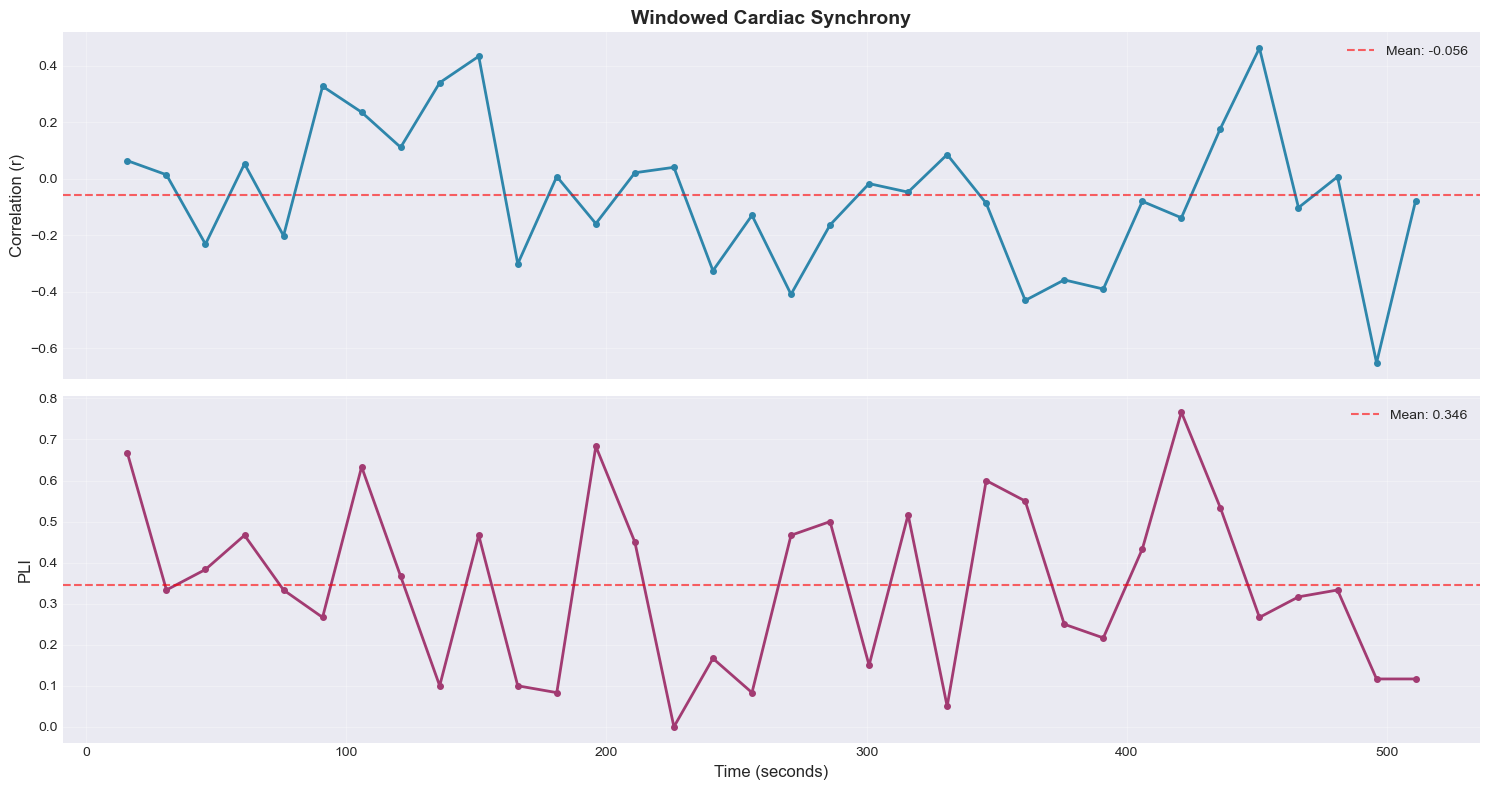

In [14]:
# Run windowed analysis
print("Computing windowed synchrony...\n")
windowed_results = windowed_synchrony_analysis(
    hr1_data, hr2_data,
    time1_data, time2_data,
    window_size_s=30,
    overlap=0.5,
    sampling_rate=4,
    methods=['correlation', 'pli']
)

print(f"Computed synchrony for {len(windowed_results)} windows")

# Extract results for plotting
window_times = [w['window_center_s'] for w in windowed_results]
window_corr = [w['correlation']['r'] for w in windowed_results]
window_pli = [w['pli']['pli'] for w in windowed_results]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

axes[0].plot(window_times, window_corr, 'o-', linewidth=2, markersize=4, color='#2E86AB')
axes[0].axhline(np.mean(window_corr), color='red', linestyle='--', alpha=0.6, 
                label=f'Mean: {np.mean(window_corr):.3f}')
axes[0].set_ylabel('Correlation (r)', fontsize=12)
axes[0].set_title('Windowed Cardiac Synchrony', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(window_times, window_pli, 'o-', linewidth=2, markersize=4, color='#A23B72')
axes[1].axhline(np.mean(window_pli), color='red', linestyle='--', alpha=0.6,
                label=f'Mean: {np.mean(window_pli):.3f}')
axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('PLI', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Results to DataFrame

In [15]:
def results_to_dataframe(results, flatten=True):
    """
    Convert synchrony results dict to pandas DataFrame.
    
    Parameters:
    -----------
    results : dict or list of dict
        Results from compute_cardiac_synchrony
    flatten : bool
        Whether to flatten nested dictionaries
        
    Returns:
    --------
    pd.DataFrame
    """
    if isinstance(results, dict):
        results = [results]
    
    rows = []
    for r in results:
        if flatten:
            row = {}
            for key, value in r.items():
                if isinstance(value, dict):
                    for subkey, subvalue in value.items():
                        row[f"{key}_{subkey}"] = subvalue
                else:
                    row[key] = value
            rows.append(row)
        else:
            rows.append(r)
    
    return pd.DataFrame(rows)

# Convert overall results to DataFrame
df_overall = results_to_dataframe(results_all)
print("Overall synchrony results:")
print(df_overall.T)  # Transpose for better viewing

# Convert windowed results to DataFrame
df_windowed = results_to_dataframe(windowed_results)
print(f"\nWindowed synchrony results: {df_windowed.shape}")
print(df_windowed[['window_center_s', 'correlation_r', 'pli_pli']].head())

Overall synchrony results:
                                    0
n_samples                        2141
duration_s                      535.0
sampling_rate                       4
correlation_r                0.531201
correlation_p                     0.0
xcorr_max_corr               0.550884
xcorr_lag_s                     -4.25
coherence_mean_coherence     0.032993
coherence_band            (0.04, 0.4)
pli_pli                      0.169547
envelope_envelope_corr       0.167859
crqa_RR                      0.019729
crqa_DET                     0.871324
crqa_L                        3.70849
crqa_LMAX                        58.0
crqa_ENT                       1.7718
crqa_LAM                     0.884476
crqa_TT                    137.480547

Windowed synchrony results: (34, 9)
   window_center_s  correlation_r   pli_pli
0          15.9775       0.064273  0.666667
1          30.9775       0.014442  0.333333
2          45.9775      -0.231153  0.383333
3          60.9775       0.053319  0.4

In [16]:
# Save results
output_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/analysis_results")
output_dir.mkdir(exist_ok=True)

df_overall.to_csv(output_dir / "synchrony_overall.csv", index=False)
df_windowed.to_csv(output_dir / "synchrony_windowed.csv", index=False)

print(f"✓ Results saved to {output_dir}/")

✓ Results saved to /Users/lena/Downloads/tutorial_dyadic_movesense/analysis_results/


## 10. Batch Processing Multiple Sessions

Example of how to process multiple dyads/sessions in a loop.

In [ ]:
def batch_synchrony_analysis(
    data_list,
    methods=['correlation', 'xcorr'],
    **kwargs
):
    """
    Process multiple dyads/sessions.
    
    Parameters:
    -----------
    data_list : list of dict
        Each dict should contain:
        - 'hr1', 'hr2': heart rate arrays
        - 'time1', 'time2': time arrays (optional)
        - 'session_id', 'dyad_id', etc.: metadata
    methods : list
        Synchrony methods to compute
    **kwargs : dict
        Additional arguments for compute_cardiac_synchrony
        
    Returns:
    --------
    pd.DataFrame : Results for all sessions
    """
    all_results = []
    
    for data in tqdm(data_list, desc="Processing sessions"):
        # Extract data
        hr1 = data['hr1']
        hr2 = data['hr2']
        time1 = data.get('time1', None)
        time2 = data.get('time2', None)
        
        # Compute synchrony
        results = compute_cardiac_synchrony(
            hr1, hr2, time1, time2,
            methods=methods,
            **kwargs
        )
        
        # Add metadata
        for key in ['session_id', 'dyad_id', 'condition', 'family', 'segment']:
            if key in data:
                results[key] = data[key]
        
        all_results.append(results)
    
    # Convert to DataFrame
    df = results_to_dataframe(all_results)
    
    return df

print(" Batch processing function loaded")
print("\nExample usage:")
print("""
data_list = [
    {
        'hr1': hr_participant1,
        'hr2': hr_participant2,
        'time1': time1,
        'time2': time2,
        'session_id': 'session1',
        'dyad_id': 'dyad01'
    },
    # ... more sessions
]

results_df = batch_synchrony_analysis(
    data_list,
    methods=['correlation', 'xcorr', 'pli'],
    sampling_rate=4
)
""")

---

## Summary

This notebook provides a **modular, reusable framework** for cardiac synchrony analysis:

### What You Can Do:

1. **Single analysis** with `compute_cardiac_synchrony()`
2. **Choose methods** flexibly via the `methods` parameter
3. **Windowed analysis** with `windowed_synchrony_analysis()`
4. **Batch processing** with `batch_synchrony_analysis()`
5. **Export to DataFrame** with `results_to_dataframe()`

### 🔧 Easy to Extend:

To add a new synchrony method:
1. Write a function that takes `x, y` and returns a dict
2. Add it to the `compute_cardiac_synchrony()` function
3. Add the method name to the `methods` list when calling

### Recommended Workflow:

**For exploration:**
- Start with `['correlation', 'xcorr']` for quick assessment
- Add `'pli'` and `'envelope'` for more detail

**For publication:**
- Use all methods for comprehensive analysis
- Compare results across methods
- Use windowed analysis to show temporal dynamics

### 🎓 Next Steps:

- Apply to your full dataset with `batch_synchrony_analysis()`
- Add statistical testing (e.g., surrogate data, permutation tests)
- Compare synchrony across experimental conditions
- Link synchrony to behavioral outcomes

---

**